In [ ]:
!pip install datasets==1.17.0 transformers[sentencepiece]==4.15.0
!pip install accelerate==0.5.1
# To run the training on TPU, you will need to uncomment the followin line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

     |████████████████████████████████| 58 kB 2.8 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,041 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


# ทำไมเราต้องเทรนการเติมคำ (Mask filling)

ในปี 2018, มีงานวิจัยงานหนึ่งที่ชื่อว่า ULMfit ได้มีแนวคิดเกี่ยวกับ language model ในการเพิ่มประสิทธิภาพโดยใช้เทคนิค "การย้ายโดเมน" (domain adaptation) โดยที่ขั้นแรกจะต้องให้โมเดลเทรนบนโดเมนทั่วๆไป (เช่น Wikipedia) จากนั้นก็เทรนแบบเดิมอีกครั้ง แต่ทำบนดาต้าเซ็ตที่สนใจ (เช่น รีวิวหนัง) จากในนั้นขั้นตอนสุดท้ายก็ Finetune บนงานที่สนใจ ทำให้ language model มีประสิทธิภาพสูงสุด!!

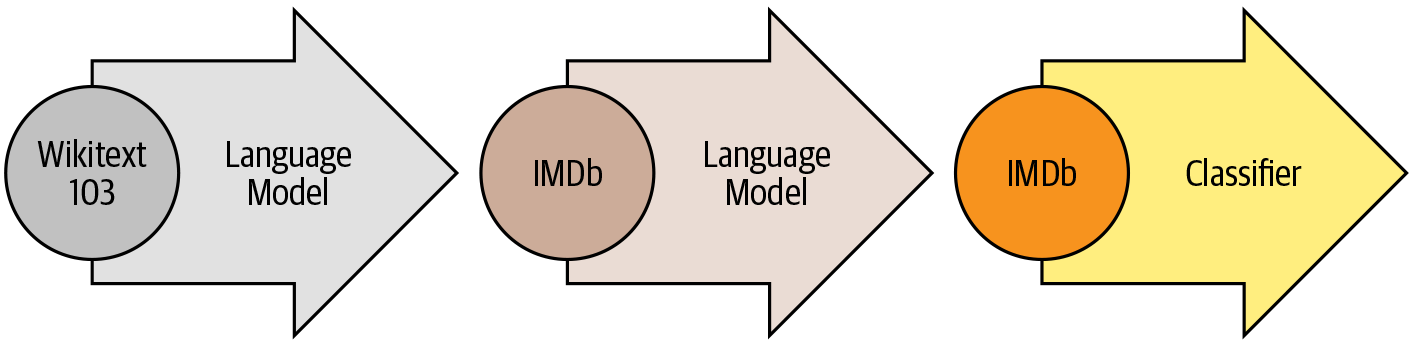

In [ ]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch

model_checkpoint = "distilbert-base-uncased" # ขนาดเล็ก เทรนง่าย
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

In [ ]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

'>>> DistilBERT number of parameters: 67M'
'>>> BERT number of parameters: 110M'


# ทดสอบการเติมคำ

In [ ]:
text = "This is a great [MASK]."

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great deal.'
'>>> This is a great success.'
'>>> This is a great adventure.'
'>>> This is a great idea.'
'>>> This is a great feat.'


# โจทย์วันนี้: เทรน Mask filling บนดาต้าเซ็ตรีวิวหนัง

In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'") # 0 = negative, 1 = positive

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f700cd6f222bd13f.arrow



'>>> Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...'
'>>> Label: 1'

'>>> Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stu

In [ ]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets 

  0%|          | 0/25 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'word_ids'],
        num_rows: 50000
    })
})

# maximum length = จำนวนที่โมเดลจำกัดในแต่ละ input
จากบทเรียนก่อนหน้า "การใส่ input ที่ยาวไป จะทำให้กินทรัพยากรเพิ่มขึ้นกว่าปกติ" ทำให้เราต้องการหนด maximum length ของโมเดลนั้นเอง (ปกติแล้ว ถ้ามีการ์ดจอแรงๆก็ใส่เยอะได้ ไม่มีปัญหา)

In [ ]:
tokenizer.model_max_length # distil-bert = 512 คำต่อ 1 input

512

In [ ]:
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 363'
'>>> Review 1 length: 304'
'>>> Review 2 length: 133'


In [ ]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'") # แต่จะเห็นได้ว่าจริงๆแล้ว input จะเกินกว่า 800 คำ

'>>> Concatenated reviews length: 800'


# ถ้าเจอ input ที่เกินจะทำยังไงดี?
= แบ่งเป็น ก้อน (chunk) สิ!

In [ ]:
chunk_size = 128
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 32'


# เทคนิคพิเศษ
= ปกติการแบ่งเป็นก้อนๆมักจะมีเศษอยู่ที่ก้อนสุดท้าย (จากตัวอย่างจะเหลือแค่ 32 คำ จาก 128 คำ) โดยเราจะเก็บไว้ก็ได้ (แต่ต้องไป padding ซึ่งออกจะยุ่งยาก) เพียงแค่ในบางตัวอย่างมันอาจจะเหลือแค่คำสองคำ ทำให้ไม่เหลือข้อมูลอะไรให้โมเดลได้เรียนรู้มากนัก ทำให้คนจึงนิยมที่จะตัดออก

In [ ]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets # ได้ข้อมูล X,y พร้อมแล้ว 

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 61291
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 59904
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 122957
    })
})

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"]) # อันที่เราอยากจะเติมคำ แต่เราต้องแอด MLM เข้าไปก่อน!!

"as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema. even ingmar bergman,"

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["labels"]) # ต้นฉบับ

"as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema. even ingmar bergman,"

แทนที่คำที่เราอยากให้โมเดลทำนายด้วย [MASK]

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15) # ใน 1 ประโยค จะให้ทำนายคำแค่ 15% ของทั้งหมด

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] i [MASK] i am curious [MASK] yellow from my video store because of all the controversy that surrounded it [MASK] it was first released in 1967. i also heard that at first it was seized by [MASK]. s. customs if it ever tried to enter this country [MASK] [MASK] being a fan of films considered " controversial " i really had to see this for [MASK] [MASK] < br / > < br [MASK] [MASK] the plot is centered around a young swedish [MASK] student named [MASK] who wants to learn everything she can about life. [MASK] particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such'

'>>> as the vietnam war and race issues in the [MASK] states [MASK] in between asking politicians and ordinary [MASK]izens of stockholm about their opinions on politics, she has sex with her [MASK] teacher, classmates, and married men. < [MASK] [MASK] > < br / > what [MASK] [MASK] about i [MASK] curious - yellow is that 40 y

แต่ปัญหาตอนนี้คือตอนที่เราแทนคำด้วย [MASK] มันดันแทนแค่คำย่อยของคำนั้นๆ(sub-word)ไม่ได้แทนทั้งหมดเช่น "bromwell => [MASK]mwell". 
เพราะฉนั้นเราจะต้องทำในสิ่งที่เรียกว่า "whole-word-mask"

In [ ]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id

    return default_data_collator(features)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk),len(chunk)}'") # หมดปัญหา


'>>> ('[CLS] i [MASK] i am curious - yellow from my video store because [MASK] [MASK] the controversy that surrounded [MASK] when [MASK] was first [MASK] in 1967. i [MASK] heard [MASK] [MASK] first it was [MASK] [MASK] [MASK]. [MASK]. [MASK] if it [MASK] tried to enter this country, therefore being a [MASK] of films considered [MASK] controversial " i [MASK] had to [MASK] this [MASK] myself. < br / > < br / > the [MASK] [MASK] centered around a young [MASK] [MASK] student named [MASK] [MASK] wants to learn everything she can [MASK] life. in particular [MASK] wants to focus her attentions to making [MASK] [MASK] of documentary on what the [MASK] swede thought about certain [MASK] issues such', 128)'

'>>> ("as [MASK] [MASK] war [MASK] race issues in the [MASK] states [MASK] [MASK] between [MASK] politicians and ordinary denizens of stockholm about their opinions on politics, [MASK] has sex [MASK] her drama teacher, classmates, and married men. < br [MASK] > < br / [MASK] what kills me 

In [ ]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 1000
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login() # เอาไว้โยนโมเดลขึ้น hugging face ได้เลย

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True, # สำหรับคนใช้ GPU
    logging_steps=logging_steps,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
)

/content/distilbert-base-uncased-finetuned-imdb is already a clone of https://huggingface.co/mrp/distilbert-base-uncased-finetuned-imdb. Make sure you pull the latest changes with `repo.git_pull()`.
Using amp half precision backend


# How to evalute LMs?
# วิธีประเมินผล language model?
เราใช้สิ่งที่เรียกว่าคะแนน "perplexity". Perplexity คือคะแนนที่ช่วยประเมินว่า "คำที่โมเดลเราทำนายนั้นถูกหรือไม่" (ยิ่งน้อยยิ่งดี) 

In [ ]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}") # โมเดลก่อนเทรน

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


>>> Perplexity: 21.94


In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids.
***** Running training *****
  Num examples = 10000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 471


Epoch,Training Loss,Validation Loss
1,2.707000,2.488302
2,2.572000,2.423960
3,2.537700,2.435494


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=471, training_loss=2.6047206907009115, metrics={'train_runtime': 1918.5724, 'train_samples_per_second': 15.637, 'train_steps_per_second': 0.245, 'total_flos': 994208670720000.0, 'train_loss': 2.6047206907009115, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}") #โมเดลหลังเทรน

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


>>> Perplexity: 11.84


In [ ]:
trainer.push_to_hub()# โยนขึ้น hugging face

Saving model checkpoint to distilbert-base-uncased-finetuned-imdb
Configuration saved in distilbert-base-uncased-finetuned-imdb/config.json
Model weights saved in distilbert-base-uncased-finetuned-imdb/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.37k/256M [00:00<?, ?B/s]

Upload file runs/Jan19_08-04-53_ff8fe0df0c19/events.out.tfevents.1642579623.ff8fe0df0c19.76.4:  68%|######8   …

Upload file runs/Jan19_08-04-53_ff8fe0df0c19/events.out.tfevents.1642581569.ff8fe0df0c19.76.6: 100%|##########…

Upload file runs/Jan19_08-04-53_ff8fe0df0c19/1642579627.893799/events.out.tfevents.1642579627.ff8fe0df0c19.76.…

Upload file runs/Jan19_08-04-53_ff8fe0df0c19/events.out.tfevents.1642579562.ff8fe0df0c19.76.3: 100%|##########…

Upload file training_args.bin: 100%|##########| 2.92k/2.92k [00:00<?, ?B/s]

To https://huggingface.co/mrp/distilbert-base-uncased-finetuned-imdb
   b0e7435..01c80f6  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Masked Language Modeling', 'type': 'fill-mask'}, 'dataset': {'name': 'imdb', 'type': 'imdb', 'args': 'plain_text'}}
To https://huggingface.co/mrp/distilbert-base-uncased-finetuned-imdb
   01c80f6..6985945  main -> main



'https://huggingface.co/mrp/distilbert-base-uncased-finetuned-imdb/commit/01c80f63e00b89c0a2c303d9233306a9dd042236'

# โจทย์พิเศษ: ในเมื่อทุกคนได้โมเดลและอัพขึ้น hugging face มาแล้ว ลองดึงเอาโมเดลลงมาใช้ดีกว่า !! 

In [ ]:
# Your code
# วิธีเรียกใช้งานให้ดู 05n_NLP_on_HF_01.ipynb